## Final Project Submission

Please fill out:
* Student name: Matthew Sparr
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli 
* Blog post URL:

## Introduction

For this project I chose a Kaggle dataset for an ongoing competition that can be found at https://www.kaggle.com/c/petfinder-adoption-prediction. This competition involves predicting the speed of adoption for a pet adoption site in Malaysia. Provided are various data fields such as the color of the pet, the age, and the breed. 

Also provided are image data on uploaded photos of the pets that was ran through Google's Vision API and sentiment data on the description given for the pets. 

## Import libraries

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os
import json
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

## Grab train and test set

The test set provided does not include the 'AdoptionSpeed' target variable and is only used to make predictions to submit to Kaggle for scoring.

In [265]:
train = pd.read_csv('train/train.csv')
test = pd.read_csv('test/test.csv')

## Fill missing values

The 'Name' and 'Description' columns are the only two columns will missing data for both the train and test set. Since both fields are text, they will be filled with a blank space, ' '.

In [4]:
train.isna().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

In [5]:
test.isna().sum()

Type              0
Name            303
Age               0
Breed1            0
Breed2            0
Gender            0
Color1            0
Color2            0
Color3            0
MaturitySize      0
FurLength         0
Vaccinated        0
Dewormed          0
Sterilized        0
Health            0
Quantity          0
Fee               0
State             0
RescuerID         0
VideoAmt          0
Description       2
PetID             0
PhotoAmt          0
dtype: int64

In [6]:
train.Name.fillna(' ', inplace=True)
train.Description.fillna(' ', inplace=True)

test.Name.fillna(' ', inplace=True)
test.Description.fillna(' ', inplace=True)

## Explore variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022794D508D0>,
      dtype=object)

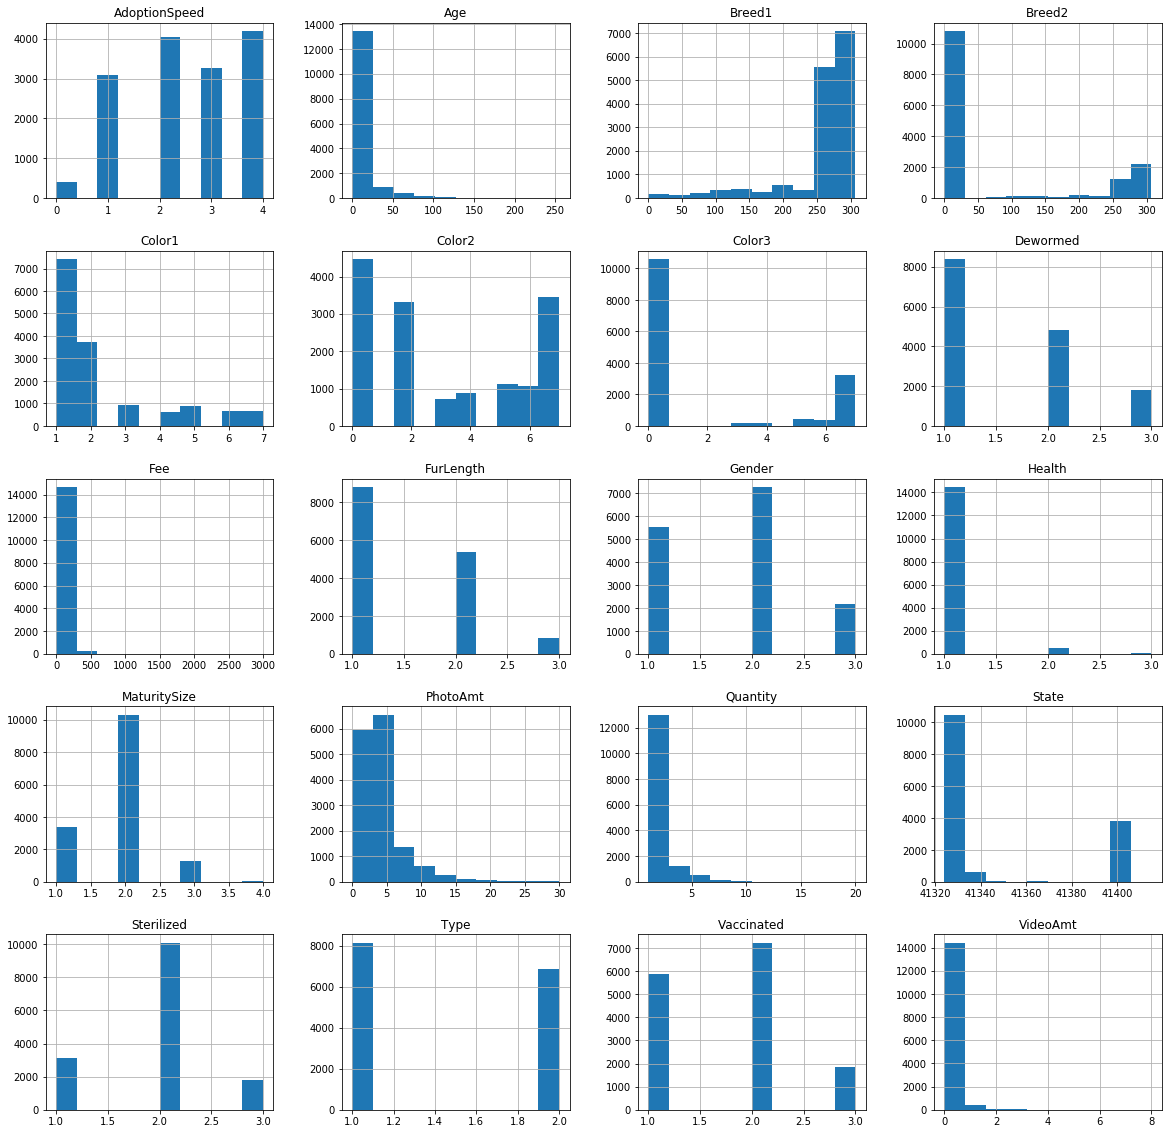

In [219]:
train.hist(figsize=(20,20))

<b>Most of the variables do not have a normal distribution which means we will probably want to standardize them later on. The target variable 'AdoptionSpeed' has a low count of '0' values which could negatively impact training a classifier on the training set.

We can also see that most pets have only one breed and one color as there are many zero values for 'Breed2', 'Color2', and 'Color3'.

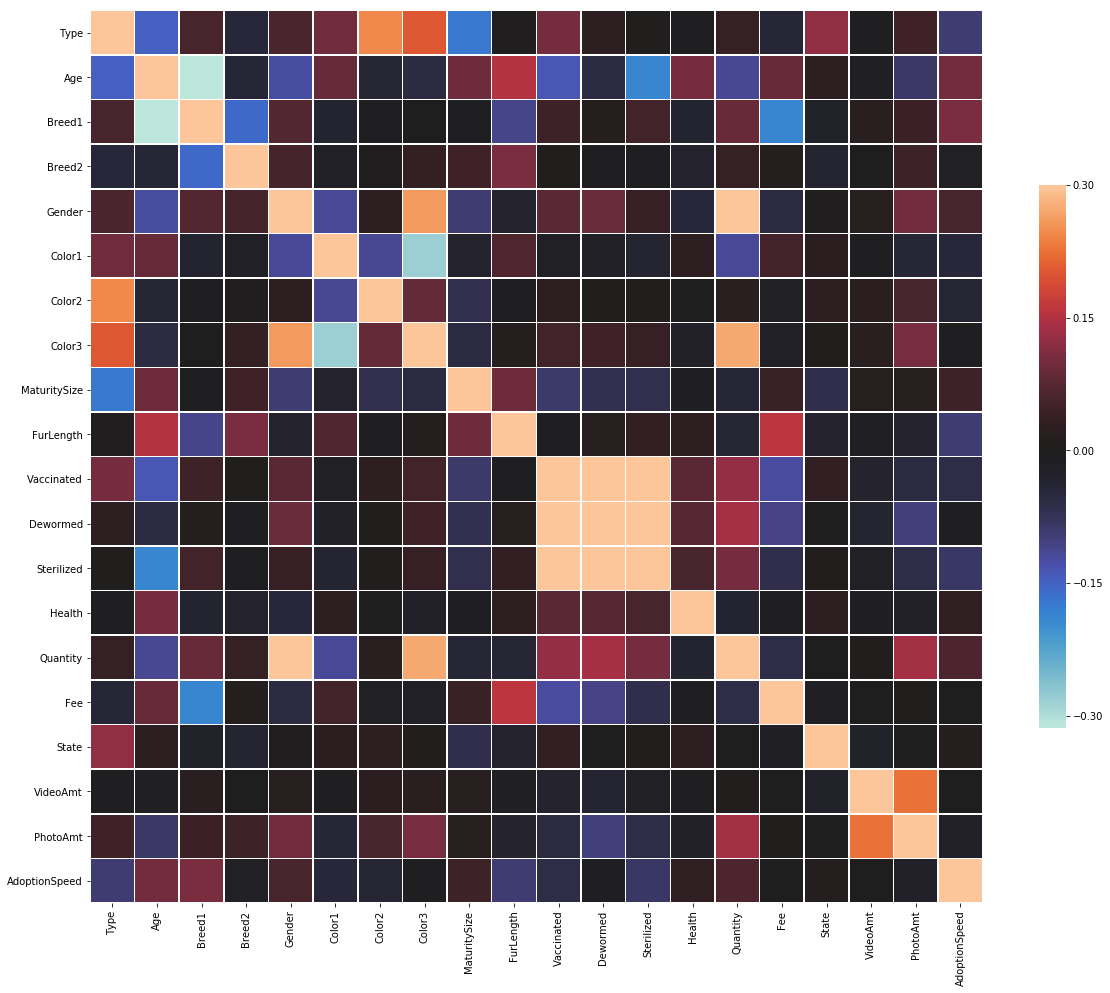

In [8]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train.corr(),vmax=.3, center=0,
            square=True, linewidths=.5,cbar_kws={"shrink": .5})

<b>From the correlation graph above we can see that the only significant correlations are between the 'Vaccinate', 'Dewormed', and 'Sterilized' variables. This is most likely due to the fact that if a pet has been taken to a vet, it is likely that all three of these treatments will be given and not just one or two of them.

We can look at the correlation coefficients below to see that 'Vaccinated' and 'Dewormed' have the highest at 0.722. This is somewhat high but not high enough to have to consider removing or combining the columns.

In [9]:
train.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()[0:10]

AdoptionSpeed  AdoptionSpeed    1.000000
Vaccinated     Dewormed         0.722596
Gender         Quantity         0.494489
Vaccinated     Sterilized       0.471204
Dewormed       Sterilized       0.426256
Breed1         Age              0.314346
Color1         Color3           0.282897
Quantity       Color3           0.272548
Color3         Gender           0.259309
Type           Color2           0.246333
dtype: float64

<b>Now we can look at some of the value counts of various columns just to get a feel of the distribution of the pets.

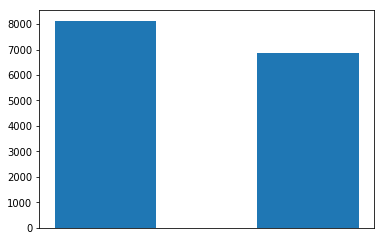

In [299]:
plt.hist(train.Type, bins=3)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

In [10]:
train.Type.value_counts()
# 1 == Dog, 2 == Cat

1    8132
2    6861
Name: Type, dtype: int64

<b>Slightly more dogs than cats.

In [11]:
train.Breed1.value_counts().head(15)

307    5927
266    3634
265    1258
299     342
264     296
292     264
285     221
141     205
205     190
179     167
218     162
109     151
254     105
103      98
243      94
Name: Breed1, dtype: int64

<b> Breed 307 which signifies an unknown breed is the most common primary breed followed by Breed 266 which are domestic shorthair cats.

In [12]:
train.Breed2.value_counts().head(15)

0      10762
307     1727
266      599
265      321
299      138
264      125
292      105
218       91
141       86
285       78
103       55
213       49
254       42
189       40
109       39
Name: Breed2, dtype: int64

<b> Most pets do not have a second breed but the largest number of the ones that do have an unknown second breed.

In [13]:
train.Gender.value_counts()
# 1 = male, 2 = female, 3 = mixed

2    7277
1    5536
3    2180
Name: Gender, dtype: int64

<b> Most pets are female with a decent amount being a mixed group of pets.

<b> From the correlation matrix, 'Breed1' and 'Age' showed the lowest correlation coefficient so I wanted to explore that fact with the below chart of 'BreedID' versus the average age of pets with that breed.

Text(0,0.5,'Average Age')

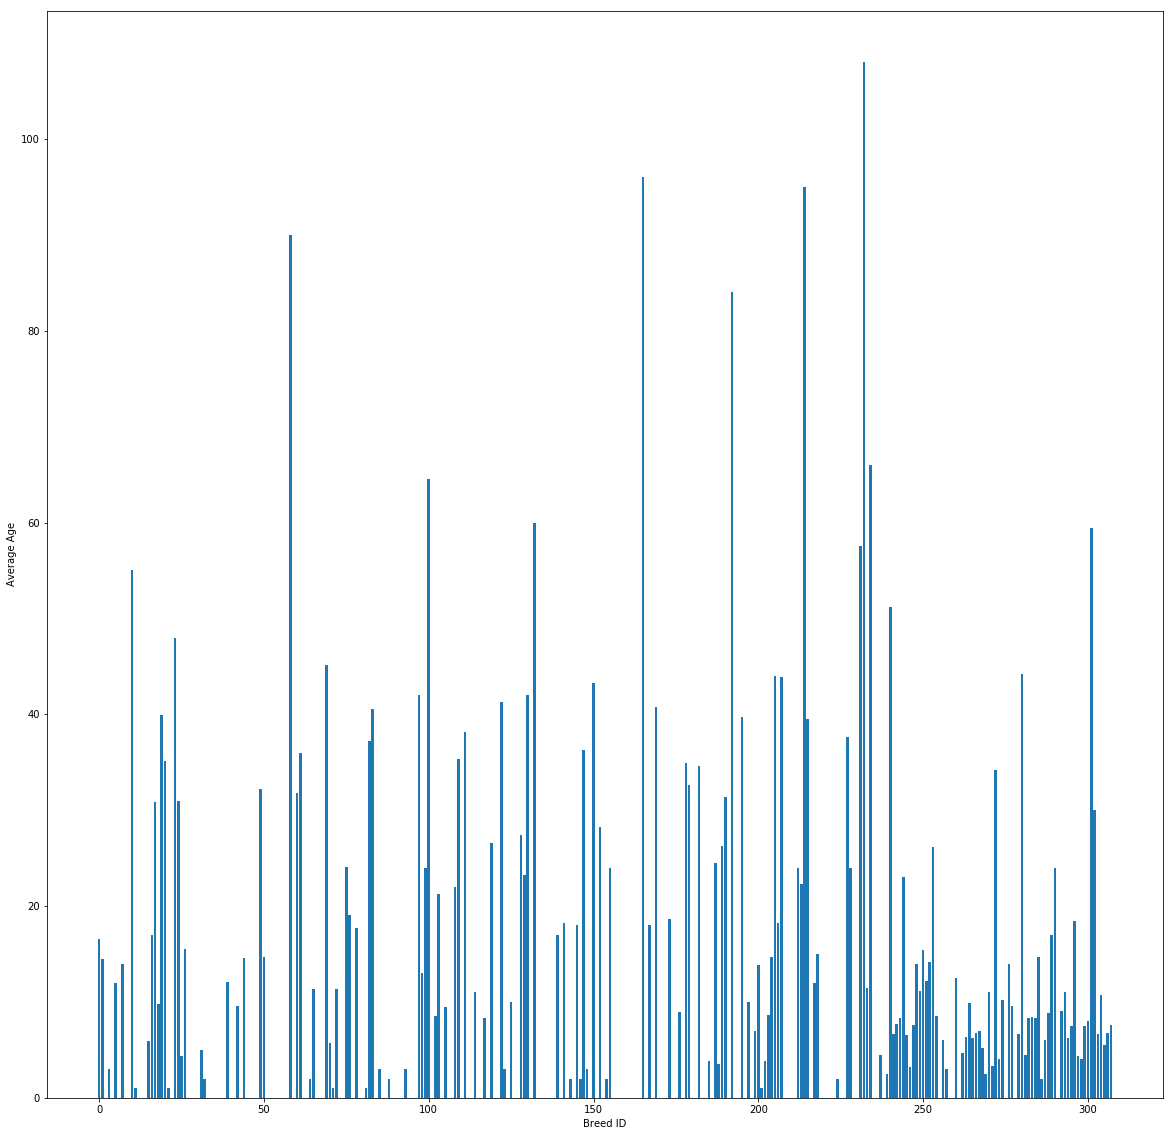

In [14]:
x = train.Breed1.unique()
y = []
for i in x:
    y.append(train.Age[train.Breed1 == i].mean())
breed_vs_age = pd.DataFrame()
breed_vs_age['Breed'] = x
breed_vs_age['Age'] = y
breed_vs_age.sort_values('Age', inplace=True)
breed_vs_age.head()
f, ax = plt.subplots(figsize=(20, 20))
plt.bar(breed_vs_age['Breed'], breed_vs_age['Age'])
plt.xlabel('Breed ID')
plt.ylabel('Average Age')

<b> From the above chart it would seem that average age of pets varies wildly with the breed. This suggests that some breeds of pets are more likely to be up for adoption at a younger age and some breeds are more likely to be put up for adoption at an older age.

## Add image metadata

<b>The image metadata is given by a collection of JSON files with the 'PetID' of the corresponding pet in the name of the file. Some pets have multiple pictures but I will initially just use the first photo of each pet if available as this is most likely the first photo seen by people searching for pets to adopt and thus has the largest effect on drawing in a perspective adoption.
  

In [15]:
for index, row in train.iterrows():
    file = 'train_metadata/' + row['PetID'] + '-1.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        train.loc[index, 'vertex_x']= vertex_x
        train.loc[index, 'vertex_y']= vertex_y
        train.loc[index, 'bounding_conf']= bounding_confidence
        train.loc[index, 'bounding_imp']= bounding_importance_frac
        train.loc[index, 'dom_blue']= dominant_blue
        train.loc[index, 'dom_green']= dominant_green
        train.loc[index, 'dom_red']= dominant_red
        train.loc[index, 'pixel_frac']= dominant_pixel_frac
        train.loc[index, 'score']= dominant_score
    else:
        train.loc[index, 'vertex_x']= -1
        train.loc[index, 'vertex_y']= -1
        train.loc[index, 'bounding_conf']= -1
        train.loc[index, 'bounding_imp']= -1
        train.loc[index, 'dom_blue']= -1
        train.loc[index, 'dom_green']= -1
        train.loc[index, 'dom_red']= -1
        train.loc[index, 'pixel_frac']= -1
        train.loc[index, 'score']= -1

In [16]:
for index, row in test.iterrows():
    file = 'test_metadata/' + row['PetID'] + '-1.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        test.loc[index, 'vertex_x']= vertex_x
        test.loc[index, 'vertex_y']= vertex_y
        test.loc[index, 'bounding_conf']= bounding_confidence
        test.loc[index, 'bounding_imp']= bounding_importance_frac
        test.loc[index, 'dom_blue']= dominant_blue
        test.loc[index, 'dom_green']= dominant_green
        test.loc[index, 'dom_red']= dominant_red
        test.loc[index, 'pixel_frac']= dominant_pixel_frac
        test.loc[index, 'score']= dominant_score
    else:
        test.loc[index, 'vertex_x']= -1
        test.loc[index, 'vertex_y']= -1
        test.loc[index, 'bounding_conf']= -1
        test.loc[index, 'bounding_imp']= -1
        test.loc[index, 'dom_blue']= -1
        test.loc[index, 'dom_green']= -1
        test.loc[index, 'dom_red']= -1
        test.loc[index, 'pixel_frac']= -1
        test.loc[index, 'score']= -1

## Add sentiment data

<b> The sentiment data, similar to the image data, is provided as JSON files with the 'PetID' of the corresponding pet as the file name.
    The relevant values I chose to include from the sentiment data are magnitude and score.

In [18]:
for index, row in train.iterrows():
    file = 'train_sentiment/' + row['PetID'] + '.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        mag = data['documentSentiment']['magnitude']
        score = data['documentSentiment']['score']     
        train.loc[index, 'magnitude']= mag
        train.loc[index, 'sentiment_score']= score
    else:
        train.loc[index, 'magnitude']= -1
        train.loc[index, 'sentiment_score']= -1

In [19]:
for index, row in test.iterrows():
    file = 'test_sentiment/' + row['PetID'] + '.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        mag = data['documentSentiment']['magnitude']
        score = data['documentSentiment']['score']     
        test.loc[index, 'magnitude']= mag
        test.loc[index, 'sentiment_score']= score
    else:
        test.loc[index, 'magnitude']= -1
        test.loc[index, 'sentiment_score']= -1

## Save data before adding addtional columns

<b> I will be adding additional columns of data but wanted to save a copy of the train and test sets to compare with later on.

In [220]:
train.to_csv('pre_train.csv')
test.to_csv('pre_test.csv')

## Add name and description length

<b> To include a bit more data on 'Description' column and the otherwise unused 'Name' column, I decided to include the length of each as new columns of data. 

In [221]:
train['NameLength'] = train['Name'].map(lambda x: 0 if x == 'None' else len(x)).astype('int')
train['DescLength'] = train['Description'].map(lambda x: len(x)).astype('int')
test['NameLength'] = test['Name'].map(lambda x: 0 if x == 'None' else len(x)).astype('int')
test['DescLength'] = test['Description'].map(lambda x: len(x)).astype('int')

TypeError: object of type 'float' has no len()

## Add dog data

<b> Using data from an AKC website as well as Wikipedia, I assigned a breed group to each dog breed as I suspect that there is a difference in adoptability amongst the dog breed groups. I added these breed groups in Microsoft Excel and generated a csv file 'dog_breeds' using the providing csv of breed labels. Now I just have to add a new column 'Group' to the train and test set. Since this only works for dogs, any cats will just be assigned the group 'Cat'.

In [21]:
dog_data = pd.read_csv('dog_breeds.csv')

In [22]:
dog_data.head()

,Unnamed: 0,BreedID,Type,BreedName,Group
0,0,1,1,Affenpinscher,Toy
1,1,2,1,Afghan Hound,Hound
2,2,3,1,Airedale Terrier,Terrier
3,3,4,1,Akbash,Working
4,4,5,1,Akita,Working


In [23]:
for index, row in train.iterrows():
    for i, r in dog_data.iterrows():
        if row['Breed1'] == r['BreedID']:
            train.at[index,'Group'] = r['Group']
            break

In [24]:
for index, row in test.iterrows():
    for i, r in dog_data.iterrows():
        if row['Breed1'] == r['BreedID']:
            test.at[index,'Group'] = r['Group']
            break

In [25]:
train.Group.isna().sum()

6853

In [26]:
dog_data.columns

Index(['Unnamed: 0', 'BreedID', 'Type', 'BreedName', 'Group'], dtype='object')

In [27]:
for index, row in train.iterrows():
    try:
        breed = row['Breed1']
        group = dog_data[dog_data['BreedID'] == breed]['Group'].values[0]
    except:
        group = 'Cat'
    train.loc[index,'Group'] = group    

In [28]:
for index, row in test.iterrows():
    try:
        breed = row['Breed1']
        group = dog_data[dog_data['BreedID'] == breed]['Group'].values[0]
    except:
        group = 'Cat'
    test.loc[index,'Group'] = group 

In [29]:
train.Group.value_counts()

Cat             6853
Misc            6018
Sporting         448
Toy              409
Working          366
Terrier          311
Non-Sporting     247
Herding          168
Hound            155
FSS               13
Hunting            5
Name: Group, dtype: int64

In [30]:
test.Group.value_counts()

Cat             2072
Misc            1323
Toy              125
Sporting         110
Working          101
Non-Sporting      70
Terrier           65
Herding           44
Hound             37
FSS                1
Name: Group, dtype: int64

<b> It seems that 'Misc' is the most common breed group apart from 'Cat'.

## Add cat data

<b> Using data from http://www.catbreedslist.com, I decided to include two new variables for the 'Cats' in the dataset. The first is 'Hypo' which is whether or not the cat breed is hypoallergenic. The second is 'Cute' which if the value in this column is 1 then that cat breed is one of the top 10 cutest cat breeds. 

In [31]:
cat_data = pd.read_csv('cat_info.csv')

In [32]:
cat_data.head()

,BreedID,Type,BreedName,Cute,Hypo
0,241,2,Abyssinian,0,0
1,242,2,American Curl,1,0
2,243,2,American Shorthair,1,0
3,244,2,American Wirehair,0,0
4,245,2,Applehead Siamese,0,0


In [33]:
for index, row in train.iterrows():
    try:
        breed = row['Breed1']
        cute = cat_data[cat_data['BreedID'] == breed]['Cute'].values[0]
        hypo = cat_data[cat_data['BreedID'] == breed]['Hypo'].values[0]
    except:
        cute = -1
        hypo = -1
    train.loc[index,'Cat_Cute'] = cute
    train.loc[index,'Cat_Hypo'] = hypo

In [34]:
for index, row in test.iterrows():
    try:
        breed = row['Breed1']
        cute = cat_data[cat_data['BreedID'] == breed]['Cute'].values[0]
        hypo = cat_data[cat_data['BreedID'] == breed]['Hypo'].values[0]
    except:
        cute = -1
        hypo = -1
    test.loc[index,'Cat_Cute'] = cute
    test.loc[index,'Cat_Hypo'] = hypo

In [35]:
train.Cat_Cute.value_counts()

-1.0    8145
 0.0    6404
 1.0     444
Name: Cat_Cute, dtype: int64

In [36]:
train.Cat_Hypo.value_counts()

-1.0    8145
 0.0    6350
 1.0     498
Name: Cat_Hypo, dtype: int64

In [37]:
test.Cat_Cute.value_counts()

 0.0    1952
-1.0    1876
 1.0     120
Name: Cat_Cute, dtype: int64

In [38]:
test.Cat_Hypo.value_counts()

 0.0    1948
-1.0    1876
 1.0     124
Name: Cat_Hypo, dtype: int64

## Add state data

<b> Using census data found on Wikipedia for the states in Malaysia, I added the population, percentage of urban environment, and population density for each state.
 

In [223]:
state_data = pd.read_csv('state_data.csv')
state_data.head()

,State,Population,StateID,UrbanPercent,PopDensity
0,Kuala Lumpur,1627172,41401,100.0,6891
1,Labuan,86908,41415,82.3,950
2,Johor,3348283,41336,71.9,174
3,Kedah,1890098,41325,64.6,199
4,Kelantan,1459994,41367,42.4,97


In [40]:
for index, row in train.iterrows():
    state = row['State']
    urban = state_data[state_data['StateID'] == state]['UrbanPercent'].values[0]
    pop = state_data[state_data['StateID'] == state]['Population'].values[0]
    pop_den = state_data[state_data['StateID'] == state]['PopDensity'].values[0]

    train.loc[index,'UrbanPercent'] = urban
    train.loc[index,'Population'] = pop
    train.loc[index,'PopDensity'] = pop_den

In [41]:
for index, row in test.iterrows():
    state = row['State']
    urban = state_data[state_data['StateID'] == state]['UrbanPercent'].values[0]
    pop = state_data[state_data['StateID'] == state]['Population'].values[0]
    pop_den = state_data[state_data['StateID'] == state]['PopDensity'].values[0]

    test.loc[index,'UrbanPercent'] = urban
    test.loc[index,'Population'] = pop
    test.loc[index,'PopDensity'] = pop_den

In [42]:
train.Population.value_counts()

5411324.0    8714
1627172.0    3845
1520143.0     843
3348283.0     507
2258428.0     420
997071.0      253
788706.0      137
1890098.0     110
1443365.0      85
1015776.0      26
3117405.0      22
1459994.0      15
2420009.0      13
86908.0         3
Name: Population, dtype: int64

In [43]:
test.Population.value_counts()

5411324.0    2018
1627172.0    1279
1520143.0     229
3348283.0     136
2258428.0     104
997071.0       55
788706.0       47
1890098.0      45
2420009.0      22
3117405.0       7
1015776.0       2
1459994.0       2
1443365.0       2
Name: Population, dtype: int64

## Save preprocessed data

In [44]:
train.to_csv('processed_train.csv')
test.to_csv('processed_test.csv')

## Import preprocessed data

In [230]:
train = pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')

## Encode categorical variables

In [232]:
train = pd.get_dummies(train, columns = ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                                 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
                                 'State', 'Type', 'Group'
                                ])
test = pd.get_dummies(test, columns = ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                                 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
                                 'State', 'Type', 'Group'
                                ])

## Make sure train and test have same columns

In [235]:
diff_columns = set(train.columns).difference(set(test.columns))
for i in diff_columns:
    test[i] = test.apply(lambda _: 0, axis=1)
diff_columns2 = set(test.columns).difference(set(train.columns))
for i in diff_columns2:
    train[i] = train.apply(lambda _: 0, axis=1)
test = test[train.columns]

In [125]:
train.shape

(14993, 435)

In [126]:
test.shape

(3948, 435)

## Set target variable

In [236]:
target = train['AdoptionSpeed'].astype('int')

## Drop irrelevent columns

In [243]:
X = train.drop(['Name', 'RescuerID', 'Description', 'PetID', 'AdoptionSpeed', 'Unnamed: 0'], axis=1)
X_pred = test.drop(['Name', 'RescuerID', 'Description', 'Unnamed: 0'], axis=1)

## Baseline XGBoost

In [244]:
clf = xgb.XGBClassifier()
clf.fit(X, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [239]:
scores = cross_val_score(clf, X, target, cv=2)

In [240]:
scores.mean()

0.40365430781541745

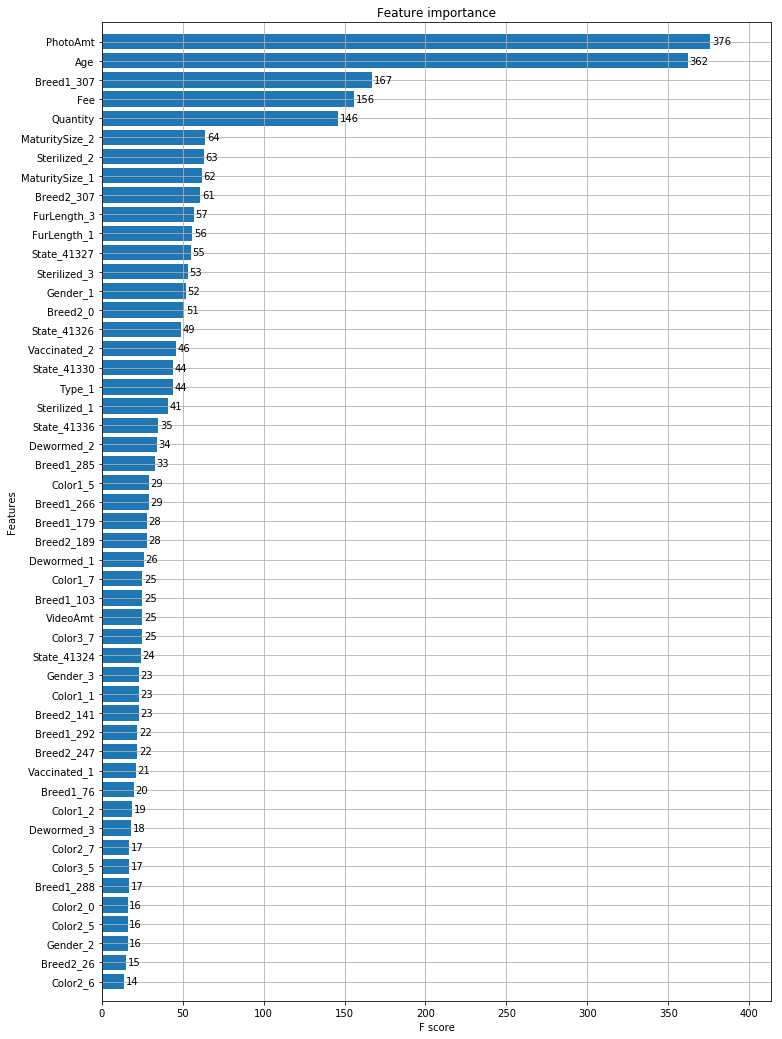

In [242]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [245]:
test_pred = clf.predict(X_pred.drop(['AdoptionSpeed','PetID'], axis=1))

In [58]:
pred = pd.DataFrame()
pred['PetID'] = X_pred['PetID']
pred['AdoptionSpeed'] = test_pred
pred.set_index('PetID').to_csv("submission.csv", index=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000227BFF72668>]],
      dtype=object)

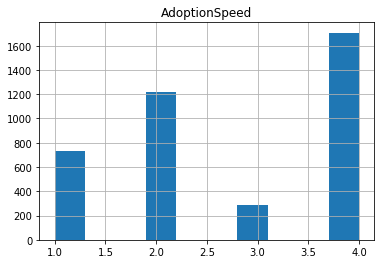

In [62]:
pred.hist()

### This received a score of 0.337 on the Kaggle competition's test data #1

In [249]:
def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [251]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

In [253]:
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


In [254]:
quadratic_weighted_kappa(target, clf.predict(X))

0.3998913422314485

## Standardization

In [143]:
X_stan = StandardScaler().fit_transform(X)

C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [144]:
test_stan = StandardScaler().fit_transform(X_pred.drop(['AdoptionSpeed','PetID'], axis=1))

C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Dimensionality reduction

In [145]:
pca = PCA(n_components=0.8, svd_solver='full', random_state=47)
principalComponents = pca.fit_transform(X_stan)

In [146]:
test_pca = pca.transform(test_stan)

## Random Forest Baseline

In [255]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_stan, target)

C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [256]:
scores = cross_val_score(clf, X_stan, target, cv=3)
scores.mean()

0.40618927365512003

In [257]:
quadratic_weighted_kappa(target, clf_rf.predict(X_stan))

0.9859424501243039

In [258]:
test_pred = clf_rf.predict(test_stan)

In [259]:
pred = pd.DataFrame()
pred['PetID'] = X_pred['PetID']
pred['AdoptionSpeed'] = test_pred
pred.set_index('PetID').to_csv("submission-rf.csv", index=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002279140C6A0>]],
      dtype=object)

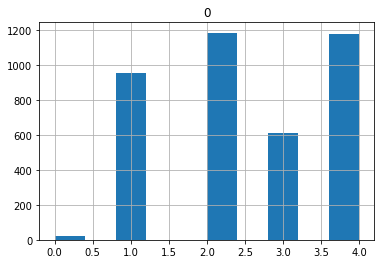

In [260]:
pd.DataFrame(test_pred).hist()

### This received a score of 0.242 on the Kaggle competition's test data #1

In [261]:
import lightgbm as lgb

d_train = lgb.Dataset(X_stan, label=target)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['num_class'] = 5
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

clf = lgb.train(params, d_train, 100)

In [262]:
preds = clf.predict(X_stan, num_iteration=clf.best_iteration)
preds_round = np.array([])
for i in preds:
    k = 0
    c = 0
    for j in i:
        if j > k:
            k = j
            c += 1
    preds_round = np.append(preds_round, c)

In [263]:
pd.DataFrame(preds)

,0,1,2,3,4
0,0.028672,0.212389,0.276491,0.213621,0.268827
1,0.028561,0.220633,0.261740,0.207142,0.281924
2,0.025203,0.204471,0.278694,0.236541,0.255091
3,0.025198,0.194609,0.262512,0.230506,0.287174
4,0.025186,0.208209,0.286982,0.216172,0.263451
5,0.027978,0.208111,0.282343,0.213277,0.268291
6,0.031063,0.212125,0.260599,0.207632,0.288580
7,0.025613,0.202703,0.283709,0.223803,0.264172
8,0.027830,0.226639,0.278091,0.214860,0.252580
9,0.028027,0.202143,0.262813,0.207768,0.299249


In [210]:
pd.DataFrame(preds_round).head()

,0
0,3.0
1,4.0
2,3.0
3,4.0
4,3.0


In [192]:
target.values.shape

(14993,)

In [196]:
preds_round.shape

(14993,)

In [211]:
accuracy_score(preds_round, target.values)

0.32335089708530645

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000227D6E9CE10>]],
      dtype=object)

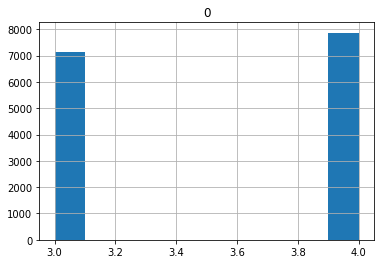

In [212]:
pd.DataFrame(preds_round).hist()